In [1]:
!pip install keract

In [17]:
# Script 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import json
from keract import get_activations
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib.patches import Rectangle
from natsort import natsorted
from tqdm import tqdm

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import *

In [19]:
os.chdir('/content/drive/MyDrive/EE113DB - Sagar')

In [20]:
os.chdir('/content/drive/MyDrive/EE113DB - Sagar')
print(os.getcwd())

dataDir = 'custom_datasets320'
dataType = 'val2017'

img_filenames = natsorted(os.listdir(os.path.join(dataDir, 'images', dataType)))
img_ids = [os.path.splitext(f)[0] for f in img_filenames] # get rid of '.jpg' extension

with open(os.path.join(dataDir, 'annotations', '{}bboxes.json'.format(dataType) ), 'r') as json_file:
  img_bboxes_dict = json.load(json_file)
  json_file.close()

'''
Custom JSON hierarchy:
img_id
    cat
        bbox1
        bbox2
        bbox3
        ...
    cat 
        bbox1
        bbox2
        bbox3
        ...
'''

/content/drive/MyDrive/EE113DB - Sagar


'\nCustom JSON hierarchy:\nimg_id\n    cat\n        bbox1\n        bbox2\n        bbox3\n        ...\n    cat \n        bbox1\n        bbox2\n        bbox3\n        ...\n'

In [21]:
model = tf.keras.models.load_model('set_yolov3-tiny.h5')
anchors = [[115, 73, 119,199, 242,238], [12, 18,  37, 49,  52,132]]
class_threshold = 0.1 # may want to lower to 0.1 for demo purposes, by default it's 0.4
input_h, input_w = 320, 320
nms_thresh = 0.25

labels = ["person", "bicycle", "car", "motorcycle", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

relevant_cats = ['car', 'bicycle', 'motorcycle', 'bus', 'truck', 
                 'traffic light', 'stop sign', 'parking meter', 'fire hydrant']
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 432         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 320, 320, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
# with open('set_yolov3.json', 'w') as json_file:
#   json_config = model.to_json()
#   y = json.loads(json_config)
#   json_file.write(json.dumps(y, indent=2))

#   json_file.close()

In [22]:
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
  grid_h, grid_w = netout.shape[:2]
  nb_box = 3
  netout = netout.reshape((grid_h, grid_w, nb_box, -1)) # Converts to 
  nb_class = netout.shape[-1] - 5
  boxes = []
  netout[..., :2]  = _sigmoid(netout[..., :2])
  netout[..., 4:]  = _sigmoid(netout[..., 4:])
  netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
  netout[..., 5:] *= netout[..., 5:] > obj_thresh

  for i in range(grid_h*grid_w):
    row = i / grid_w
    col = i % grid_w
    for b in range(nb_box):
      # 4th element is objectness score
      objectness = netout[int(row)][int(col)][b][4]
      if(objectness.all() <= obj_thresh): continue
      # first 4 elements are x, y, w, and h
      x, y, w, h = netout[int(row)][int(col)][b][:4]
      x = (col + x) / grid_w # center position, unit: image width
      y = (row + y) / grid_h # center position, unit: image height
      w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
      h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
      # last elements are class probabilities
      classes = netout[int(row)][col][b][5:]
      box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
      boxes.append(box)
  return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

In [23]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def load_img_array(image_path, target_size=(320,320)):
  image = load_img(image_path, target_size=target_size)
  image = img_to_array(image)
  
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0

  return image

**Network Output Verification** 
With given max pool issue, can lower class threshold and network kind of "works" with propagated error

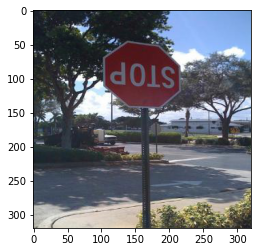

In [24]:
img_num = 0 # TODO - change img_num to match C output (use 0 or 1)
a = open('test_images/test_bin_image%d.float32' % img_num, 'rb')
img_np = np.fromfile(a, dtype=np.float32).reshape(320,320,3)
plt.imshow(img_np)
img_np = np.expand_dims(img_np, axis=0)

In [25]:
p_prediction = model.predict(img_np)

cp1 = np.fromfile('/content/drive/MyDrive/EE113DB - Sagar/C_Outputs/test_bin_response_image%d_10by10by255.float32' % img_num, dtype=np.float32).reshape(1, 10,10,255)
cp2 = np.fromfile('/content/drive/MyDrive/EE113DB - Sagar/C_Outputs/test_bin_response_image%d_20by20by255.float32' % img_num, dtype=np.float32).reshape(1, 20,20,255)
c_prediction = [cp1, cp2]

[(1, 10, 10, 255), (1, 20, 20, 255)]


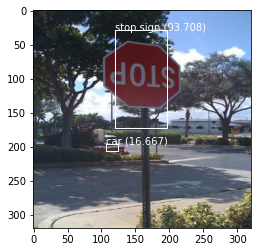

In [26]:
print([a.shape for a in p_prediction])
boxes = []
for i in range(len(p_prediction)):
  boxes += decode_netout(p_prediction[i][0], anchors[i], class_threshold, input_h, input_w)

img_path = os.path.join(dataDir, 'images', dataType,  img_filenames[img_num])
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, 320, 320, 320, 320)

# Suppress non-maximal (confidences) boxes with high overlap (IoU)
do_nms(boxes, nms_thresh)

# Get bounding boxes above score theshold
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# TODO - only for demo & debug purposes
draw_boxes(img_path, v_boxes, v_labels, v_scores) 

[(1, 10, 10, 255), (1, 20, 20, 255)]


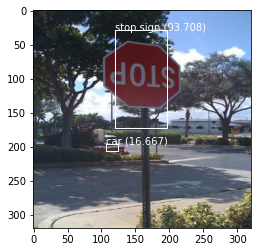

In [27]:
print([a.shape for a in c_prediction])
boxes = []
for i in range(len(c_prediction)):
  boxes += decode_netout(c_prediction[i][0], anchors[i], class_threshold, input_h, input_w)

img_path = os.path.join(dataDir, 'images', dataType,  img_filenames[img_num])
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, 320, 320, 320, 320)

# Suppress non-maximal (confidences) boxes with high overlap (IoU)
do_nms(boxes, nms_thresh)

# Get bounding boxes above score theshold
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# TODO - only for demo & debug purposes
draw_boxes(img_path, v_boxes, v_labels, v_scores) 

**Activation Verification**

In [28]:
layer_names = [layer.name for layer in model.layers]
layer_output_shapes = [layer.output_shape[1:4] for layer in model.layers]
C_output_filenames = []
layer_activations = []
activations = get_activations(model, img_np, layer_names = layer_names)


for i in range(len(layer_names)):
  C_output_filenames.append(layer_names[i] + '_output.float32')
  y = activations[layer_names[i]]
  y = np.squeeze(y, axis = 0)
  layer_activations.append(y)


print(os.getcwd())
print(layer_names)
print(C_output_filenames)
print(layer_output_shapes)


/content/drive/My Drive/EE113DB - Sagar
['image_input', 'conv2d', 'batch_normalization', 'leaky_re_lu', 'max_pooling2d', 'conv2d_1', 'batch_normalization_1', 'leaky_re_lu_1', 'max_pooling2d_1', 'conv2d_2', 'batch_normalization_2', 'leaky_re_lu_2', 'max_pooling2d_2', 'conv2d_3', 'batch_normalization_3', 'leaky_re_lu_3', 'max_pooling2d_3', 'conv2d_4', 'batch_normalization_4', 'leaky_re_lu_4', 'max_pooling2d_4', 'conv2d_5', 'batch_normalization_5', 'leaky_re_lu_5', 'max_pooling2d_5', 'conv2d_6', 'batch_normalization_6', 'leaky_re_lu_6', 'conv2d_7', 'batch_normalization_7', 'leaky_re_lu_7', 'conv2d_10', 'batch_normalization_9', 'leaky_re_lu_9', 'up_sampling2d', 'concatenate', 'conv2d_8', 'conv2d_11', 'batch_normalization_8', 'batch_normalization_10', 'leaky_re_lu_8', 'leaky_re_lu_10', 'conv2d_9', 'conv2d_12']
['image_input_output.float32', 'conv2d_output.float32', 'batch_normalization_output.float32', 'leaky_re_lu_output.float32', 'max_pooling2d_output.float32', 'conv2d_1_output.float32', 

In [29]:
# Start at "1" because we skip input layer
for i in range(1, len(layer_names)): 
  c_activation = np.reshape(np.fromfile('C_Outputs/' + C_output_filenames[i], dtype=np.float32), layer_output_shapes[i])
  p_activation = layer_activations[i]

  diff = np.abs(c_activation - p_activation)
  print(layer_names[i], ': ', np.max(diff))

  # if layer_names[i] == 'max_pooling2d':
  #   for j in range(16):
  #     plt.imshow(diff[:,:,j])
  #     plt.show()

conv2d :  3.8146973e-06
batch_normalization :  2.9087067e-05
leaky_re_lu :  1.7166138e-05
max_pooling2d :  1.7166138e-05
conv2d_1 :  6.484985e-05
batch_normalization_1 :  3.8146973e-05
leaky_re_lu_1 :  1.9878149e-05
max_pooling2d_1 :  1.9878149e-05
conv2d_2 :  6.1035156e-05
batch_normalization_2 :  3.4332275e-05
leaky_re_lu_2 :  2.002716e-05
max_pooling2d_2 :  1.8119812e-05
conv2d_3 :  6.1035156e-05
batch_normalization_3 :  2.7656555e-05
leaky_re_lu_3 :  1.9073486e-05
max_pooling2d_3 :  1.9073486e-05
conv2d_4 :  4.005432e-05
batch_normalization_4 :  2.9563904e-05
leaky_re_lu_4 :  1.692772e-05
max_pooling2d_4 :  1.692772e-05
conv2d_5 :  3.4332275e-05
batch_normalization_5 :  2.193451e-05
leaky_re_lu_5 :  2.002716e-05
max_pooling2d_5 :  2.002716e-05
conv2d_6 :  2.9563904e-05
batch_normalization_6 :  0.00011634827
leaky_re_lu_6 :  8.392334e-05
conv2d_7 :  6.198883e-05
batch_normalization_7 :  3.0517578e-05
leaky_re_lu_7 :  3.0517578e-05
conv2d_10 :  1.3828278e-05
batch_normalization_9 :  

**Same vs. Valid Pooling**

In [ ]:
# same vs. valid padding for maxpool2d
pool_layer_same = model.get_layer(name='max_pooling2d')
pool_layer_valid = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid')


x = np.expand_dims(layer_activations[3], axis=0)

y1 = pool_layer_same(x)
y2 = pool_layer_valid(x)

diff = abs(y1-y2)
print(np.max(diff))

0.0
